In [27]:
import pandas as pd
import numpy as np

# load the data
file_url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"
df = pd.read_csv(file_url)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [28]:
# select relevant data
relevant_proximities = ['<1H OCEAN','INLAND']
df = df[df['ocean_proximity'].isin(relevant_proximities)]

#### Preparation

In [29]:
# Fill missing values with zeros.
df.fillna(0, inplace=True)

# Apply the log tranform to median_house_value.
df['median_house_value'] = np.log1p(df.median_house_value)

# Do train/validation/test split with 60%/20%/20% distribution.
from sklearn.model_selection import train_test_split

# shuffle the dataset using seed 42
n = len(df)
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)
df_shuffled = df.iloc[idx]

# Use the train_test_split function and set the random_state parameter to 1.
# split the data into train/val/test with 60%/20%/20%
df_full, df_test = train_test_split(df_shuffled, test_size=np.round(len(df)*.2).astype(int), random_state=1)
#df_full, df_test = train_test_split(df, test_size=np.round(len(df)*.2).astype(int), random_state=1)
df_train, df_val = train_test_split(df_full, test_size=np.round(len(df)*.2).astype(int), random_state=1)

df_full = df_full.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['median_house_value'].values
y_val = df_val['median_house_value'].values
y_test = df_test['median_house_value'].values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [30]:
# Use DictVectorizer(sparse=True) to turn the dataframes into matrices.
from sklearn.feature_extraction import DictVectorizer

In [31]:
features = df_train.columns.to_list()
df_train_dict=df_train[features].to_dict(orient='records')
df_val_dict=df_val[features].to_dict(orient='records')
df_test_dict=df_test[features].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(df_train_dict)

DictVectorizer(sparse=False)

In [32]:
X_train = dv.transform(df_train_dict)
X_val = dv.transform(df_val_dict)
X_test = dv.transform(df_test_dict)

### Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable.

Train a model with `max_depth=1.`

In [33]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

In [8]:
## TRAINING THE REGRESSION MODEL:
#dt = DecisionTreeRegressor(max_depth=1)
#dt.fit(X_train, y_train)
#
## INSPECTION:
#print(export_text(dt, feature_names=dv.feature_names_))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



In [34]:
# when using shuffled data
# TRAINING THE REGRESSION MODEL:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

# INSPECTION:
print(export_text(dt, feature_names=dv.feature_names_))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.29]



### Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1 (optional-to make training faster)`

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [36]:
# TRAINING RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [11]:
## CALCULATING MEAN SQUARED ERROR:
#y_pred = rf.predict(X_val)
#np.sqrt(mean_squared_error(y_val, y_pred))

0.24295542481334761

In [37]:
# when using shuffled data
# CALCULATING MEAN SQUARED ERROR:
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

0.243165082730577

### Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.

In [38]:
from tqdm.auto import tqdm

In [39]:
#@ TRAINING THE RANDOM FOREST MODEL:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

100%|██████████| 20/20 [01:11<00:00,  3.59s/it]


In [40]:
import matplotlib.pyplot as plt

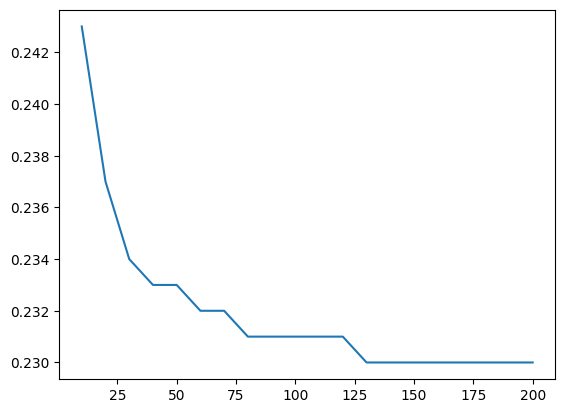

In [15]:
## INSPECTING THE RMSE SCORES:
#plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))
#plt.show()

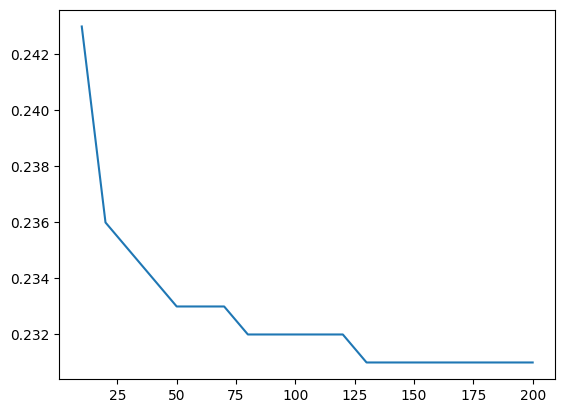

In [41]:
# when using shuffled data
# INSPECTING THE RMSE SCORES:
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))
plt.show()

### Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`

In [42]:
# TRAINING THE MODEL WITH DEPTH:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

 25%|██▌       | 1/4 [00:04<00:14,  4.84s/it]

100%|██████████| 4/4 [00:26<00:00,  6.71s/it]


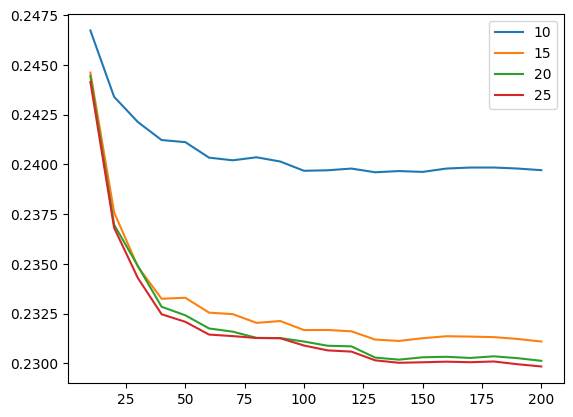

In [17]:
## PLOTTING THE GRAPH:
#for d in [10, 15, 20, 25]:
#    df_subset = df_scores[df_scores.max_depth == d]
#    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)
#
#plt.legend()
#plt.show()

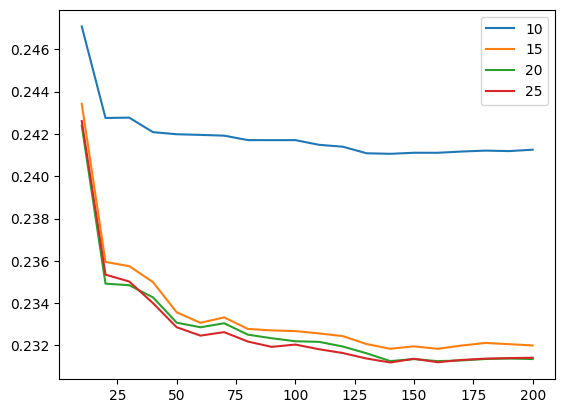

In [43]:
# when using shuffled data
# PLOTTING THE GRAPH:
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

### Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_` field.

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,  
  * `max_depth=20`,  
  * `random_state=1`,  
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


In [44]:
# TRAINING RANDOM FOREST MODEL:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)


# GET FEATURE IMPORTANCE INFORMATION
rf.feature_importances_

array([0.01692841, 0.03238418, 0.10033626, 0.08480385, 0.33802454,
       0.25146463, 0.10886211, 0.0291485 , 0.01735475, 0.02069277])

In [19]:
#sorted([z for z in zip(dv.feature_names_, rf.feature_importances_)], key=lambda x: x[1], reverse=True)[:3]

[('median_income', 0.33557258143991675),
 ('ocean_proximity=INLAND', 0.18252985653883133),
 ('ocean_proximity=<1H OCEAN', 0.18152397342639143)]

In [45]:
sorted([z for z in zip(dv.feature_names_, rf.feature_importances_)], key=lambda x: x[1], reverse=True)[:3]

[('median_income', 0.3380245415020496),
 ('ocean_proximity=<1H OCEAN', 0.251464626226877),
 ('ocean_proximity=INLAND', 0.10886211437874364)]

### Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change eta from 0.3 to 0.1.

In [46]:
import xgboost as xgb
import re

In [47]:
# CREATING THE DMARTIX:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [48]:
# INITIALIZATION:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}
iters = list(np.arange(0,100))

# TRAIN AND SAVE RESULTS
for eta in [0.3, 0.1]:
    xgb_params = {
        'eta': eta, 
        'max_depth': 6,
        'min_child_weight': 1,

        'objective': 'reg:squarederror',
        'nthread': 8,

        'seed': 1,
        'verbosity': 1,
        }
        
    evals_result = {}
    model = xgb.train(xgb_params, dtrain, num_boost_round=100, evals=watchlist, evals_result=evals_result)
    scores[eta] = evals_result['val']['rmse']

[0]	train-rmse:0.44032	val-rmse:0.44710
[1]	train-rmse:0.36429	val-rmse:0.37451
[2]	train-rmse:0.31443	val-rmse:0.32798
[3]	train-rmse:0.28324	val-rmse:0.30024
[4]	train-rmse:0.26331	val-rmse:0.28238
[5]	train-rmse:0.25111	val-rmse:0.27310
[6]	train-rmse:0.23928	val-rmse:0.26358
[7]	train-rmse:0.23094	val-rmse:0.25803
[8]	train-rmse:0.22380	val-rmse:0.25310
[9]	train-rmse:0.21861	val-rmse:0.25038
[10]	train-rmse:0.21315	val-rmse:0.24783
[11]	train-rmse:0.21022	val-rmse:0.24652
[12]	train-rmse:0.20641	val-rmse:0.24376
[13]	train-rmse:0.20275	val-rmse:0.24215
[14]	train-rmse:0.19927	val-rmse:0.24112
[15]	train-rmse:0.19504	val-rmse:0.23880
[16]	train-rmse:0.19262	val-rmse:0.23834
[17]	train-rmse:0.18953	val-rmse:0.23841
[18]	train-rmse:0.18673	val-rmse:0.23713
[19]	train-rmse:0.18498	val-rmse:0.23675
[20]	train-rmse:0.18305	val-rmse:0.23666
[21]	train-rmse:0.18106	val-rmse:0.23661
[22]	train-rmse:0.17890	val-rmse:0.23589
[23]	train-rmse:0.17750	val-rmse:0.23553
[24]	train-rmse:0.17559	va

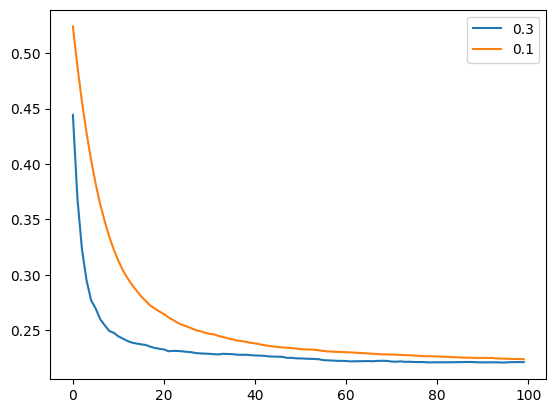

In [23]:
#plt.plot(iters, scores[0.3], label='0.3')
#plt.plot(iters, scores[0.1], label='0.1')
#plt.legend()
#plt.show()

In [25]:
#scores[0.3][-1], scores[0.1][-1]

(0.22120167723175732, 0.22386154115975868)

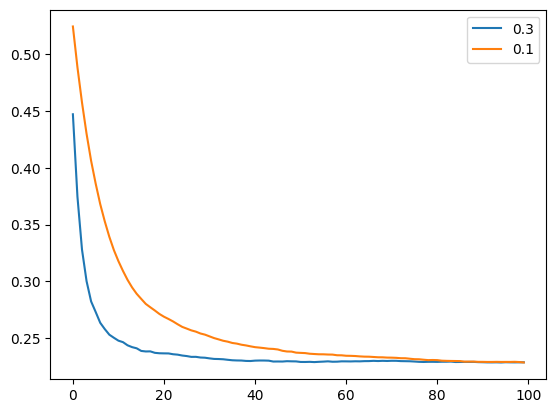

In [49]:
# when using shuffled data
plt.plot(iters, scores[0.3], label='0.3')
plt.plot(iters, scores[0.1], label='0.1')
plt.legend()
plt.show()

In [50]:
# when using shuffled data
scores[0.3][-1], scores[0.1][-1]

(0.22878577226415442, 0.22864988234607142)